## Setup

In [ ]:
! pip install neuralogic
from neuralogic.core import Template, R, V
from neuralogic.dataset import Dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 21.5 MB/s eta 0:00:00


/usr/local/lib/python3.8/dist-packages/neuralogic/core/builder/builder.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
template = Template()

# GNN-like graph propagation
template +=  R.layer_1(V.X) <= (R.bond(V.X, V.Y, V.B))

## Bonding rules

In [ ]:
## check bonding rules if working well

template += R.single_bonded(V.X, V.Y) <= (R.bond(V.X, V.Y, V.B), R.b_1(V.B))
#template += R.single_bonded(V.X, V.Y) <= (R.bond(V.Y, V.X, V.B), R.b_1(V.B))

template += R.double_bonded(V.X, V.Y) <= (R.bond(V.X, V.Y, V.B), R.b_2(V.B))
#template += R.double_bonded(V.X, V.Y) <= (R.bond(V.Y, V.X, V.B), R.b_2(V.B))

template += R.triple_bonded(V.X, V.Y) <= (R.bond(V.X, V.Y, V.B), R.b_3(V.B))
#template += R.triple_bonded(V.X, V.Y) <= (R.bond(V.Y, V.X, V.B), R.b_3(V.B))


# aromatic, ionic, ...
template += R.aromatic_bonded(V.X, V.Y) <= (R.bond(V.X, V.Y, V.B), R.b_7(V.B))

## Saturation

In [ ]:
from neuralogic.core import Aggregation

template += R.saturated(V.X) <= (R.c(V.X),
                                 R.single_bonded(V.X, V.Y1),
                                 R.single_bonded(V.X, V.Y2),
                                 R.single_bonded(V.X, V.Y3),
                                 R.single_bonded(V.X, V.Y4),
                                 R.special.alldiff(...))
template += (R.saturated <= (R.saturated(V.X))) | [Aggregation.MIN]

## Hydrocarbons

### Dataset definition

In [ ]:
train_dataset = Dataset()
train_dataset.add_example(
    [
        R.c(1), R.h(2), R.h(3), R.h(4), R.h(5), # methane
        R.bond(1, 2, 10), R.bond(1, 3, 11), R.bond(1, 4, 12), R.bond(1, 5, 13),
        R.b_1(10), R.b_1(11), R.b_1(12), R.b_1(13)
    ],
)
train_dataset.add_example(
    [
        R.c(1), R.h(2), R.h(3), R.c(4), R.h(5), R.h(6), # ethene
        R.bond(1, 2, 10), R.bond(1, 3, 11), R.bond(6, 4, 12), R.bond(4, 5, 13), R.bond(1, 4, 14),
        R.b_1(10), R.b_1(11), R.b_1(12), R.b_1(13), R.b_2(14)
    ],
)
train_dataset.add_example(
    [
        R.c(1), R.h(2), R.c(3), R.c(4), R.h(5), R.h(6), R.h(7), # propyne
        R.bond(1, 2, 10), R.bond(1, 3, 11), R.bond(3, 4, 12), R.bond(4, 5, 13), R.bond(4, 6, 14), R.bond(4, 7, 15),
        R.b_1(10), R.b_3(11), R.b_1(12), R.b_1(13), R.b_1(14), R.b_1(15)
    ],
)
train_dataset.add_example(
    [
        R.o(1), R.h(2), R.o(3), R.o(4), R.s(5), R.i(6), R.h(7), # dummy molecule
        R.bond(1, 2, 10), R.bond(1, 3, 11), R.bond(3, 4, 12), R.bond(4, 5, 13), R.bond(4, 6, 14), R.bond(4, 7, 15),
        R.b_1(10), R.b_3(11), R.b_1(12), R.b_1(13), R.b_2(14), R.b_1(15)
    ],
)


Alkanes

In [ ]:
# molecule is an alkane if all carbon atoms are saturated & it only contains C & H
#template += R.not_hydrocarbyl(V.Mol) <= (R.contains(V.Mol, V.X), ~R.c(V.X), ~R.h(V.X))

#template += R.not_alkane(V.Mol) <= (R.contains(V.Mol, V.C), ~R.saturated(V.C))
#template += R.not_alkane(V.Mol) <= (~R.not_hydrocarbyl(V.Mol))
#template += R.alkane(V.Mol) <= (~R.not_alkane(V.Mol))
#######################################
#template += R.not_hydrocarbyl <= ~R.c(V.X), ~R.h(V.X)

#template += R.not_alkane <= ~R.saturated(V.C)
#template += R.not_alkane <= ~R.hidden.not_hydrocarbyl
#template += R.alkane <= ~R.hidden.not_alkane
#######################################

template += R.not_c_or_h <= (~R.c(V.X), ~R.h(V.X)) # maybe aggregation max
template += R.alkane <= (R.saturated, ~R.hidden.not_c_or_h)

Alkenes

In [ ]:
'''template += R.alkene <= (~R.not_c_or_h, 
                          R.c(V.C1), R.c(V.C2),
                          R.double_bonded(V.C1, V.C2))''' # if there exists a double bond between carbons

template += R.alkene_bond(V.C1, V.C2) <= (R.c(V.C1), R.c(V.C2), R.double_bonded(V.C1, V.C2))

Alkynes

In [ ]:
'''template += R.alkyne <= (~R.not_c_or_h, 
                          R.c(V.C1), R.c(V.C2),
                          R.triple_bonded(V.C1, V.C2))''' # if there exists a triple bond between carbons

template += R.alkyne_bond(V.C1, V.C2) <= (R.c(V.C1), R.c(V.C2), R.triple_bonded(V.C1, V.C2))

Phenyl group

In [ ]:
template += R.benzene_ring(V.A, V.B, V.C, V.D, V.E, V.F) <= (R.aromatic_bonded(V.A, V.B), 
                                         R.aromatic_bonded(V.B, V.C),
                                         R.aromatic_bonded(V.C, V.D),
                                         R.aromatic_bonded(V.D, V.E),
                                         R.aromatic_bonded(V.E, V.F),
                                         R.aromatic_bonded(V.F, V.A),
                                         R.c(V.A), R.c(V.B), R.c(V.C),
                                         R.c(V.D), R.c(V.E), R.c(V.F),
                                         R.special.alldiff(...))

## Predicition

layer_1(X) :- bond(X, Y, B).
single_bonded(X, Y) :- bond(X, Y, B), b_1(B).
double_bonded(X, Y) :- bond(X, Y, B), b_2(B).
triple_bonded(X, Y) :- bond(X, Y, B), b_3(B).
aromatic_bonded(X, Y) :- bond(X, Y, B), b_7(B).
saturated(X) :- c(X), single_bonded(X, Y1), single_bonded(X, Y2), single_bonded(X, Y3), single_bonded(X, Y4), @alldiff(Y1, Y2, X, Y4, Y3).
saturated :- saturated(X). [aggregation=min]
alkyne :- ~*not_c_or_h, c(C1), c(C2), triple_bonded(C1, C2).
benzene_ring(A, B) :- aromatic_bonded(A, B), aromatic_bonded(B, C), aromatic_bonded(C, D), aromatic_bonded(D, E), aromatic_bonded(E, F), aromatic_bonded(F, A), @alldiff(E, B, D, F, C, A).
{1} predict :- layer_1(X).
{1} predict :- alkyne.


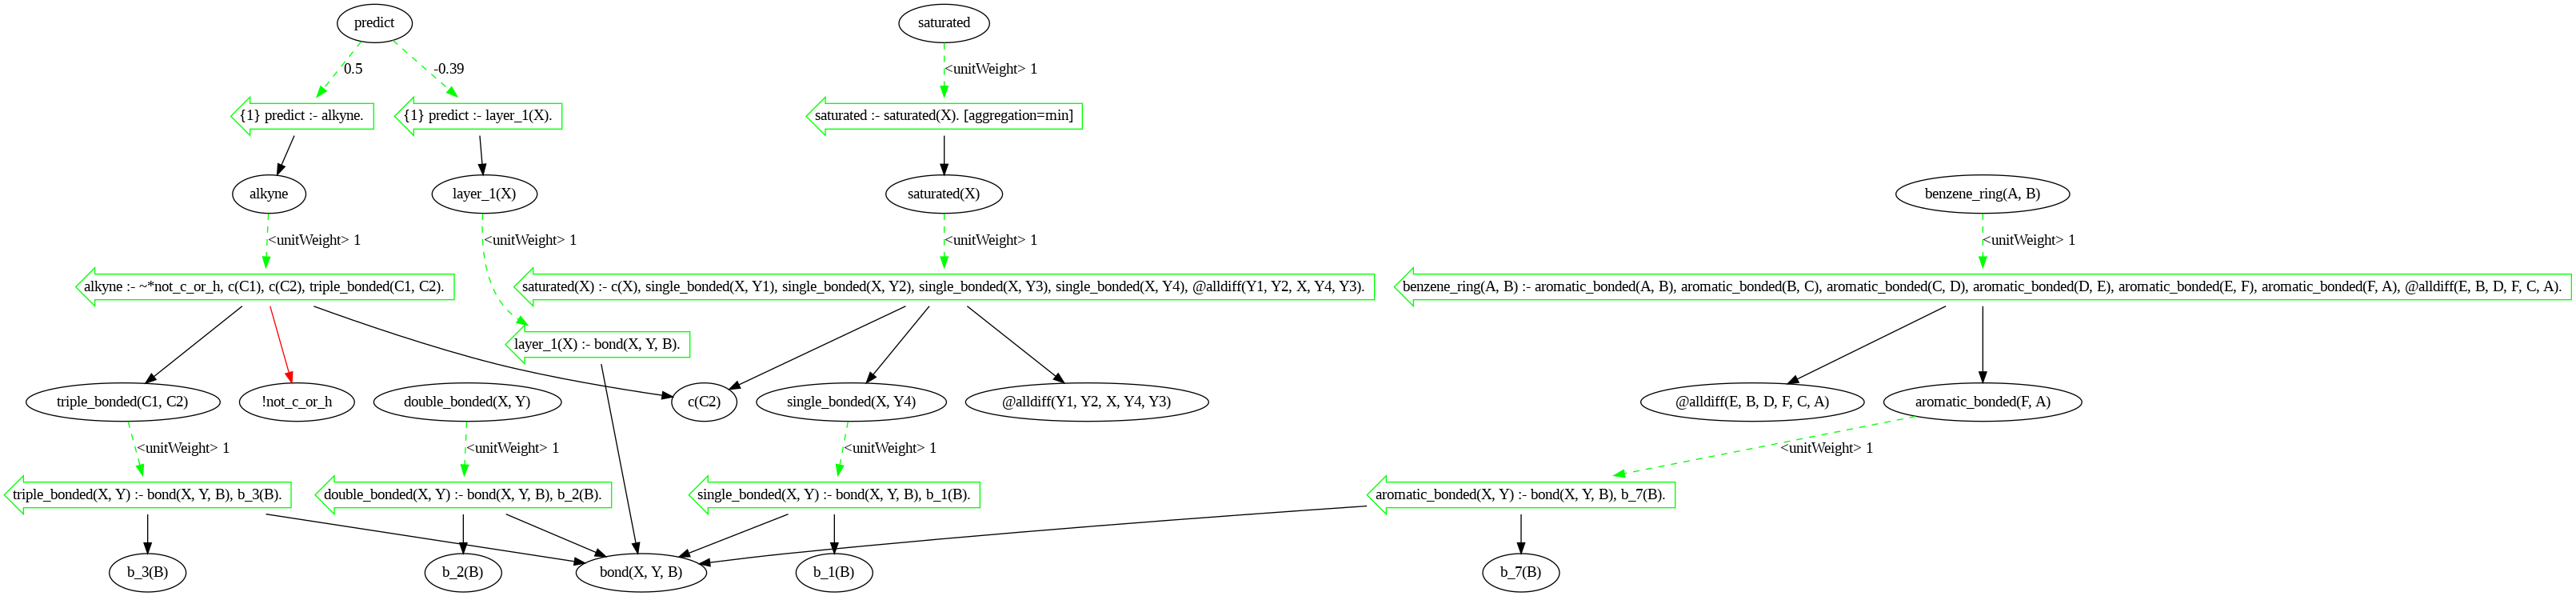

In [ ]:
template += R.predict[1,] <= R.layer_1(V.X)
template += R.predict[1,] <= R.alkyne


train_dataset.add_queries([
    R.predict[0],
    R.predict[1],
    R.predict[0],
    R.predict[0],
])
print(template)
template.draw()

## Haloalkanes

### Dataset definition

In [ ]:
train_dataset = Dataset()
train_dataset.add_example(
    [
        R.c(1), R.h(2), R.h(3), R.h(4), R.cl(5), # methyl chloride
        R.bond(1, 2, 10), R.bond(1, 3, 11), R.bond(1, 4, 12), R.bond(1, 5, 13),
        R.b_1(10), R.b_1(11), R.b_1(12), R.b_1(13)
    ],
)
train_dataset.add_example(
    [
        R.c(1), R.h(2), R.h(3), R.c(4), R.h(5), R.f(6), # ethyl fluoride
        R.bond(1, 2, 10), R.bond(1, 3, 11), R.bond(6, 4, 12), R.bond(4, 5, 13), R.bond(1, 4, 14),
        R.b_1(10), R.b_1(11), R.b_1(12), R.b_1(13), R.b_1(14)
    ],
)
train_dataset.add_example(
    [
        R.c(1), R.h(2), R.h(3), R.h(4), R.c(5), R.h(6), R.br(7), R.c(8), R.h(9), R.h(10), # propyl bromide
        R.bond(1, 2, 11), R.bond(1, 3, 12), R.bond(1, 4, 13), R.bond(5, 1, 14), R.bond(6, 5, 15), R.bond(5, 7, 16), R.bond(5, 8, 17), R.bond(9, 8, 18), R.bond(10, 8, 19),
        R.b_1(11), R.b_1(12), R.b_1(13), R.b_1(14), R.b_1(15), R.b_1(16), R.b_1(17), R.b_1(18), R.b_1(19)
    ],
)
train_dataset.add_example(
    [
        R.c(1), R.h(2), R.h(3), R.c(4), R.h(5), R.i(6), # ethyl iodide
        R.bond(1, 2, 10), R.bond(1, 3, 11), R.bond(6, 4, 12), R.bond(4, 5, 13), R.bond(1, 4, 14),
        R.b_1(10), R.b_1(11), R.b_1(12), R.b_1(13), R.b_1(14)
    ],
)

train_dataset.add_example(
    [
        R.cl(1), R.h(2), # hydrochloric acid
        R.bond(1, 2, 10),
        R.b_1(10)
    ],
)
train_dataset.add_example(
    [
        R.f(1), R.h(2), # hydrofluoric acid
        R.bond(1, 2, 10),
        R.b_1(10)
    ],
)
train_dataset.add_example(
    [
        R.br(1), R.h(2), R.o(3), # hypobromous acid
        R.bond(1, 3, 10), R.bond(2, 3, 11),
        R.b_1(10), R.b_1(11)
    ],
)
train_dataset.add_example(
    [
        R.k(1), R.i(2), # potassium iodide
        R.bond(1, 2, 10),
        R.b_1(10)
    ],
)


In [ ]:
# all carbons saturated & there exists a F, Cl, Br or I atom
template += R.haloalkane(V.Mol) <= R.fluoroalkane(V.Mol)
template += R.haloalkane(V.Mol) <= R.chloroalkane(V.Mol)
template += R.haloalkane(V.Mol) <= R.bromoalkane(V.Mol)
template += R.haloalkane(V.Mol) <= R.iodoalkane(V.Mol)

In [ ]:
template += R.fluoroalkane(V.Mol) <= (R.saturated(V.Mol), 
                                      R.contains(V.Mol, V.F), R.f(V.F), 
                                      R.contains(V.Mol, V.C), R.single_bonded(V.C, V.F))

template += R.chloroalkane(V.Mol) <= (R.saturated(V.Mol), 
                                      R.contains(V.Mol, V.Cl), R.cl(V.Cl), 
                                      R.contains(V.Mol, V.C), R.single_bonded(V.C, V.Cl))

template += R.bromoalkane(V.Mol) <= (R.saturated(V.Mol), 
                                     R.contains(V.Mol, V.Br), R.br(V.Br), 
                                     R.contains(V.Mol, V.C), R.single_bonded(V.C, V.Br))

template += R.iodoalkane(V.Mol) <= (R.saturated(V.Mol), 
                                    R.contains(V.Mol, V.I), R.i(V.I), 
                                    R.contains(V.Mol, V.C), R.single_bonded(V.C, V.I))

## Predicition

layer_1(X) :- bond(X, Y, B).
single_bonded(X, Y) :- bond(X, Y, B), b_1(B).
double_bonded(X, Y) :- bond(X, Y, B), b_2(B).
triple_bonded(X, Y) :- bond(X, Y, B), b_3(B).
aromatic_bonded(X, Y) :- bond(X, Y, B), b_7(B).
saturated(X) :- c(X), single_bonded(X, Y1), single_bonded(X, Y2), single_bonded(X, Y3), single_bonded(X, Y4), @alldiff(Y1, Y2, Y3, Y4, X).
saturated :- saturated(X). [aggregation=min]
not_hydrocarbyl :- ~*c(X).
~*h(X).
not_alkane :- ~*saturated(C).
not_alkane :- ~*not_hydrocarbyl.
alkane :- ~*not_alkane.
{1} predict :- layer_1(X).
{1} predict :- alkane.
{1} predict :- layer_1(X).
{1} predict :- saturated(X).


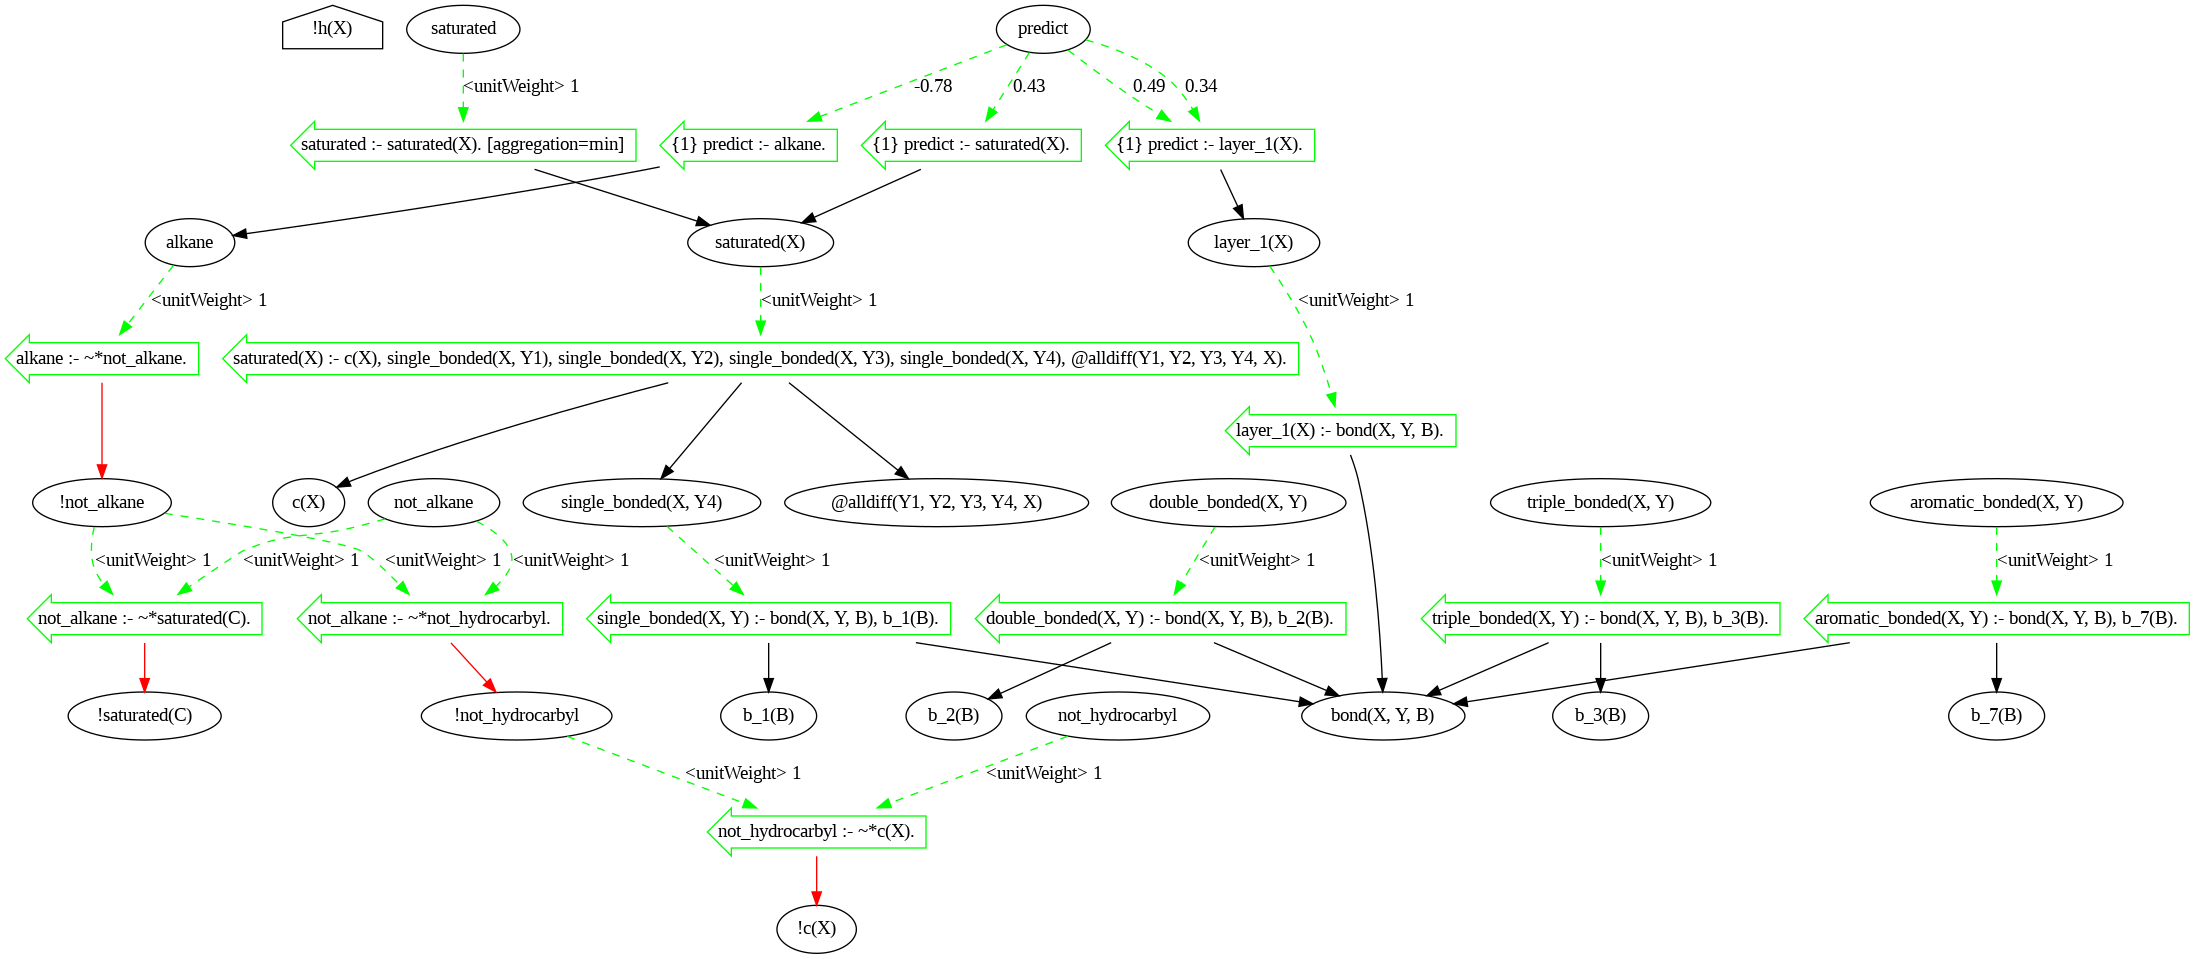

In [ ]:
template += R.predict[1,] <= R.layer_1(V.X)
template += R.predict[1,] <= R.saturated(V.X)

train_dataset.add_queries([
    R.predict[0],
    R.predict[1],
])
print(template)
template.draw()

## Training

In [ ]:
from neuralogic.core import Settings
from neuralogic.nn.loss import MSE, CrossEntropy
from neuralogic.nn import get_evaluator
from neuralogic.optim import Adam

settings = Settings(optimizer=Adam(lr=0.1), epochs=100, error_function=CrossEntropy())
evaluator = get_evaluator(template, settings)

built_dataset = evaluator.build_dataset(train_dataset)

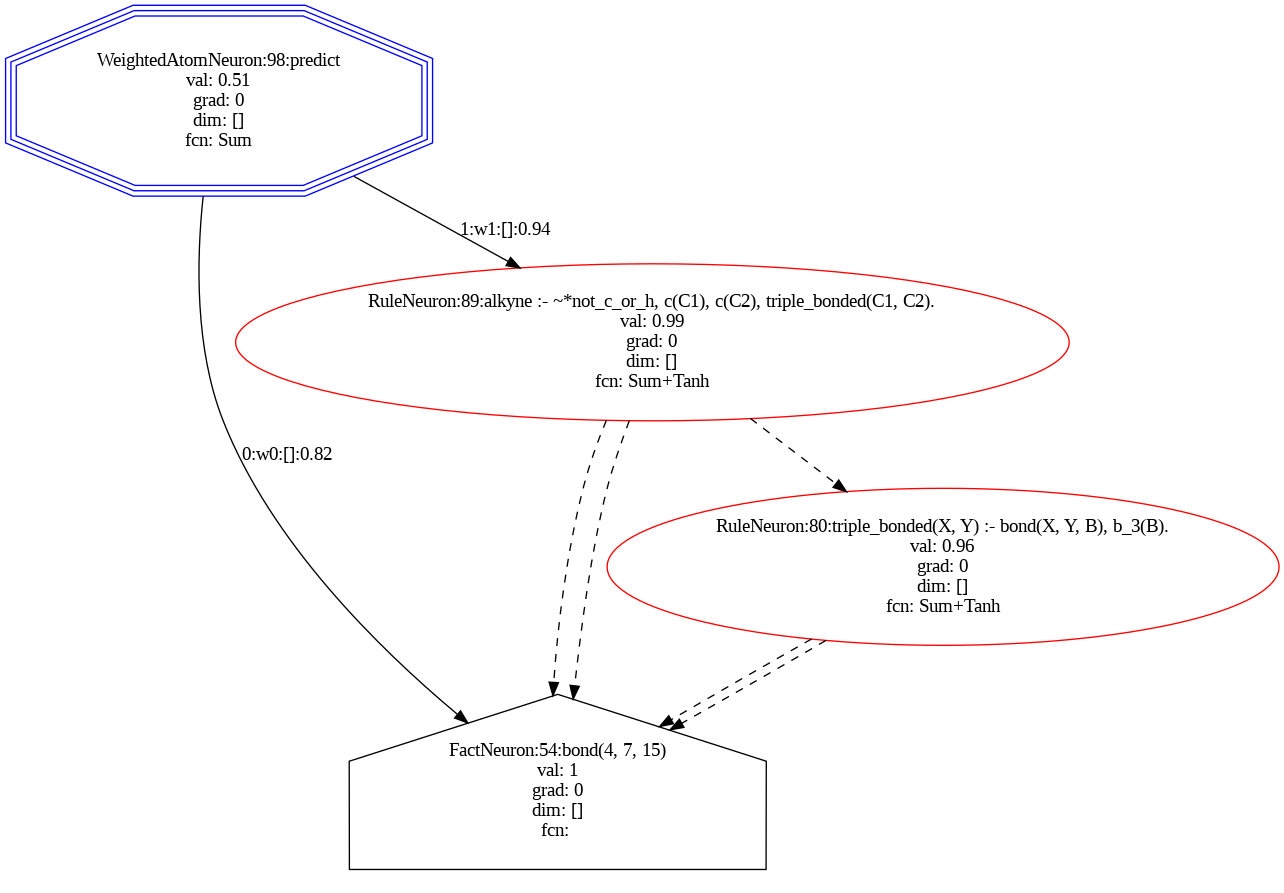

In [ ]:
built_dataset[2].draw()

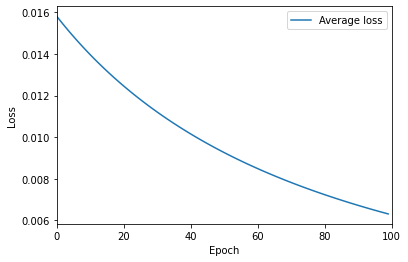

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

average_losses = []

for current_total_loss, number_of_samples in evaluator.train(built_dataset):
    clear_output(wait=True)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")

    plt.xlim(0, settings.epochs)

    average_losses.append(current_total_loss / number_of_samples)
    
    plt.plot(average_losses, label="Average loss")

    plt.legend()
    plt.pause(0.001)
    plt.show()

In [ ]:
for sample, y_hat in zip(built_dataset.samples, evaluator.test(built_dataset)):
    print(f"Target: {sample.java_sample.target}, Predicted: {round(y_hat)} ({y_hat})")

Target: 0, Predicted: -5 (-5.278113937970102)
Target: 1, Predicted: 5 (4.616509333198496)
Target: 0, Predicted: -5 (-5.278113937970102)
Target: 0, Predicted: -5 (-5.278113937970102)
